In [1]:
# =============================================================================
# MÓDULO 1: Ingestão e Exploração Inicial dos Dados
# =============================================================================
# Dataset: Olist Brazilian E-Commerce (Kaggle)
# Tabelas carregadas neste módulo:
#   olist_orders_dataset.csv         -> ciclo de vida dos pedidos
#   olist_order_payments_dataset.csv -> meios e valores de pagamento
# Esta célula inspeciona a estrutura bruta antes de qualquer transformação.
# =============================================================================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

CAMINHO = r'C:\Users\alexandre.souza\Desktop\trabalho\github\tesourara'

df_orders   = pd.read_csv(rf'{CAMINHO}\olist_orders_dataset.csv')
df_payments = pd.read_csv(rf'{CAMINHO}\olist_order_payments_dataset.csv')

for nome, df in [('PEDIDOS', df_orders), ('PAGAMENTOS', df_payments)]:
    print('=' * 80)
    print(f'TABELA DE {nome} — Shape: {df.shape} | Nulos: {df.isnull().sum().sum()}')
    print('=' * 80)
    print(df.head(3).to_string())
    print()
    df.info()
    print()


TABELA DE PEDIDOS — Shape: (99441, 8) | Nulos: 4908
                           order_id                       customer_id order_status order_purchase_timestamp    order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13           2017-10-18 00:00:00
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45           2018-08-13 00:00:00
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23          2018-08-08 13:50:00           2018-08-17 18:06:29           2018-09-04 00:00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440

In [2]:
# =============================================================================
# MÓDULO 2: Tratamento de Tipos, Limpeza e Join
# =============================================================================
# Etapas:
#   1. Conversão de colunas de data: object -> datetime64
#   2. Filtro de elegibilidade financeira
#   3. Join das tabelas de pedidos e pagamentos via order_id
#
# Critérios de exclusão:
#   order_approved_at nulo   -> pedido sem evento financeiro reconhecível
#   order_status == canceled -> sem direito a recebível
# =============================================================================

colunas_data = [
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in colunas_data:
    df_orders[col] = pd.to_datetime(df_orders[col])

n_antes = len(df_orders)
df_validos = df_orders.dropna(subset=['order_approved_at'])
df_validos = df_validos[df_validos['order_status'] != 'canceled']
n_depois   = len(df_validos)
print(f'Pedidos removidos pelo filtro: {n_antes - n_depois:,} ({(n_antes-n_depois)/n_antes*100:.1f}%)')

df_tesouraria = pd.merge(
    df_validos[['order_id', 'order_status', 'order_approved_at']],
    df_payments,
    on='order_id',
    how='inner'
)
df_tesouraria['data_aprovacao'] = df_tesouraria['order_approved_at'].dt.normalize()

print(f'Tabela unificada: {df_tesouraria.shape[0]:,} linhas x {df_tesouraria.shape[1]} colunas')
print(df_tesouraria.head().to_string())

dist = df_tesouraria['payment_type'].value_counts().to_frame('transacoes')
dist['pct'] = (dist['transacoes'] / dist['transacoes'].sum() * 100).round(1)
print('\nDISTRIBUICAO POR MEIO DE PAGAMENTO:')
print(dist.to_string())


Pedidos removidos pelo filtro: 644 (0.6%)
Tabela unificada: 103,203 linhas x 8 colunas
                           order_id order_status   order_approved_at  payment_sequential payment_type  payment_installments  payment_value data_aprovacao
0  e481f51cbdc54678b7cc49136f2d6af7    delivered 2017-10-02 11:07:15                   1  credit_card                     1          18.12     2017-10-02
1  e481f51cbdc54678b7cc49136f2d6af7    delivered 2017-10-02 11:07:15                   3      voucher                     1           2.00     2017-10-02
2  e481f51cbdc54678b7cc49136f2d6af7    delivered 2017-10-02 11:07:15                   2      voucher                     1          18.59     2017-10-02
3  53cdb2fc8bc7dce0b6741e2150273451    delivered 2018-07-26 03:24:27                   1       boleto                     1         141.46     2018-07-26
4  47770eb9100c2d0c44946d9cf07ec65d    delivered 2018-08-08 08:55:23                   1  credit_card                     3         179.12     

In [3]:
# =============================================================================
# MÓDULO 3: Projeção de Recebíveis (Inflow) — Desdobramento de Parcelas
# =============================================================================
# Regras de liquidação por meio de pagamento (premissas de modelagem):
#
#   MEIO              LIQUIDAÇÃO    OBSERVAÇÃO
#   Boleto            D+2           Compensação na rede bancária
#   Débito            D+1           Liquidação via rede de débito
#   Voucher           D+0           Compensação imediata
#   Crédito (parcela) D+30*n        Cada parcela liquidada em múltiplos de 30d
#
# NOTA: valores BRUTOS. O fluxo líquido exige desconto do MDR (Merchant
# Discount Rate) de cada operadora. Em produção, datas vêm da adquirente.
# =============================================================================
import pandas as pd
import numpy as np

df_proj = df_tesouraria.copy()
df_proj['data_aprovacao'] = pd.to_datetime(df_proj['data_aprovacao'])

df_cc     = df_proj[df_proj['payment_type'] == 'credit_card'].copy()
df_outros = df_proj[df_proj['payment_type'] != 'credit_card'].copy()

# Liquidacao: Boleto, Debito, Voucher
dias_liq = {'boleto': 2, 'debit_card': 1, 'voucher': 0}
df_outros['dias_liq']         = df_outros['payment_type'].map(dias_liq).fillna(0).astype(int)
df_outros['data_recebimento'] = df_outros['data_aprovacao'] + pd.to_timedelta(df_outros['dias_liq'], unit='D')
df_outros['valor_recebido']   = df_outros['payment_value']
df_outros['parcela_atual']    = 1

# Liquidacao: Cartao de Credito — parcela minima = 1 previne divisao por zero
df_cc['payment_installments'] = df_cc['payment_installments'].clip(lower=1)
df_cc['parcela_atual'] = df_cc['payment_installments'].apply(lambda n: list(range(1, int(n)+1)))
df_cc_exp = df_cc.explode('parcela_atual').copy()
df_cc_exp['parcela_atual']    = df_cc_exp['parcela_atual'].astype(int)
df_cc_exp['valor_recebido']   = df_cc_exp['payment_value'] / df_cc_exp['payment_installments']
df_cc_exp['dias_liq']         = df_cc_exp['parcela_atual'] * 30
df_cc_exp['data_recebimento'] = df_cc_exp['data_aprovacao'] + pd.to_timedelta(df_cc_exp['dias_liq'], unit='D')

df_fluxo_caixa = pd.concat([df_outros, df_cc_exp], ignore_index=True)
df_fluxo_caixa = df_fluxo_caixa.sort_values(['data_aprovacao', 'order_id', 'parcela_atual'])

pedido = '47770eb9100c2d0c44946d9cf07ec65d'
cols   = ['order_id', 'payment_type', 'payment_installments',
          'parcela_atual', 'data_aprovacao', 'data_recebimento', 'valor_recebido']
print('=' * 100)
print(f'DESDOBRAMENTO DE PARCELAS — Pedido: {pedido}')
print('=' * 100)
print(df_fluxo_caixa[df_fluxo_caixa['order_id'] == pedido][cols].to_string(index=False))

tot_orig = df_proj['payment_value'].sum()
tot_proj = df_fluxo_caixa['valor_recebido'].sum()
ok = abs(tot_orig - tot_proj) < 0.01
print(f'\nRECONCILIACAO FINANCEIRA:')
print(f'  Transacoes originais  : {len(df_proj):>10,}')
print(f'  Recebiveis projetados : {len(df_fluxo_caixa):>10,}')
print(f'  Total original   (R$) : {tot_orig:>15,.2f}')
print(f'  Total projetado  (R$) : {tot_proj:>15,.2f}')
print(f'  Status               : {chr(10003) if ok else "ATENCAO: divergencia"}')


DESDOBRAMENTO DE PARCELAS — Pedido: 47770eb9100c2d0c44946d9cf07ec65d
                        order_id payment_type  payment_installments  parcela_atual data_aprovacao data_recebimento  valor_recebido
47770eb9100c2d0c44946d9cf07ec65d  credit_card                     3              1     2018-08-08       2018-09-07       59.706667
47770eb9100c2d0c44946d9cf07ec65d  credit_card                     3              2     2018-08-08       2018-10-07       59.706667
47770eb9100c2d0c44946d9cf07ec65d  credit_card                     3              3     2018-08-08       2018-11-06       59.706667

RECONCILIACAO FINANCEIRA:
  Transacoes originais  :    103,203
  Recebiveis projetados :    294,535
  Total original   (R$) :   15,862,973.82
  Total projetado  (R$) :   15,862,973.82
  Status               : ✓


In [4]:
# =============================================================================
# MÓDULO 4: Estimativa de Saídas (Outflow)
# =============================================================================
# Componentes de outflow modelados:
#   Frete (freight_value) : custo integral, saída no D+0 da aprovação
#   Repasse ao Seller     : (1 - take_rate) * valor dos itens
#
# Limitações deste modelo simplificado:
#   - MDR e tarifas bancárias não incluídos
#   - Devoluções e estornos não modelados
#   - Saídas reais devem ser extraídas do ERP/financeiro em produção
# =============================================================================
import pandas as pd

CAMINHO   = r'C:\Users\alexandre.souza\Desktop\trabalho\github\tesourara'
TAKE_RATE = 0.10

try:
    df_items = pd.read_csv(rf'{CAMINHO}\olist_order_items_dataset.csv')

    ids_validos       = df_tesouraria['order_id'].unique()
    df_items_filtrado = df_items[df_items['order_id'].isin(ids_validos)]

    df_out = df_items_filtrado.groupby('order_id').agg(
        frete_total = ('freight_value', 'sum'),
        valor_itens = ('price', 'sum')
    ).reset_index()

    df_out['repasse_seller'] = df_out['valor_itens'] * (1 - TAKE_RATE)
    df_out['receita_plat']   = df_out['valor_itens'] * TAKE_RATE
    df_out['total_saidas']   = df_out['frete_total'] + df_out['repasse_seller']

    df_out = df_out.merge(
        df_tesouraria[['order_id', 'data_aprovacao']].drop_duplicates(),
        on='order_id', how='left'
    )
    df_out['data_aprovacao'] = pd.to_datetime(df_out['data_aprovacao'])

    df_saidas_diarias = (
        df_out.groupby('data_aprovacao')['total_saidas']
        .sum().rename('total_saidas_BRL').sort_index()
    )

    _outflow_ok = True
    print('Arquivo de itens carregado com sucesso.')
    print(f'  Pedidos mapeados             : {len(df_out):,}')
    print(f'  Total Frete          (R$)    : {df_out["frete_total"].sum():>15,.2f}')
    print(f'  Total Repasse Sellers(R$)    : {df_out["repasse_seller"].sum():>15,.2f}')
    print(f'  Total Saidas Estim.  (R$)    : {df_out["total_saidas"].sum():>15,.2f}')
    print(f'  Receita Plataforma   (R$)    : {df_out["receita_plat"].sum():>15,.2f}  (take rate {TAKE_RATE*100:.0f}%)')

except FileNotFoundError:
    _outflow_ok       = False
    df_saidas_diarias = None
    print('=' * 70)
    print('AVISO: olist_order_items_dataset.csv nao encontrado.')
    print('=' * 70)
    print(f'  Caminho esperado: {CAMINHO}\\olist_order_items_dataset.csv')
    print('  Download: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce')
    print('  Modulos seguintes executarao apenas com inflow projetado.')


Arquivo de itens carregado com sucesso.
  Pedidos mapeados             : 98,190
  Total Frete          (R$)    :    2,240,966.43
  Total Repasse Sellers(R$)    :   12,145,142.73
  Total Saidas Estim.  (R$)    :   14,386,109.16
  Receita Plataforma   (R$)    :    1,349,460.30  (take rate 10%)


In [5]:
# =============================================================================
# MÓDULO 5: Consolidação do Vetor de Liquidez Diária
# =============================================================================
# Objetivo: agregar o inflow por data e canal, incorporar as saídas estimadas
# e gerar o saldo líquido e acumulado — base de todas as análises seguintes.
# =============================================================================
import pandas as pd

# Agregacao do inflow: data x canal
df_caixa_diario = (
    df_fluxo_caixa
    .groupby(['data_recebimento', 'payment_type'])['valor_recebido']
    .sum().reset_index()
)

df_rel = df_caixa_diario.pivot(
    index='data_recebimento', columns='payment_type', values='valor_recebido'
).fillna(0)
df_rel.columns.name = None
df_rel['total_entradas_BRL'] = df_rel.sum(axis=1)
df_rel = df_rel.round(2).sort_index()
df_rel.index = pd.to_datetime(df_rel.index)

# Incorporacao do outflow e calculo do saldo
if _outflow_ok and df_saidas_diarias is not None:
    df_saldo = df_rel[['total_entradas_BRL']].join(df_saidas_diarias, how='outer').fillna(0)
else:
    df_saldo = df_rel[['total_entradas_BRL']].copy()
    df_saldo['total_saidas_BRL'] = 0.0

df_saldo['saldo_liquido_BRL']   = df_saldo['total_entradas_BRL'] - df_saldo['total_saidas_BRL']
df_saldo['saldo_acumulado_BRL'] = df_saldo['saldo_liquido_BRL'].cumsum()

df_relatorio_caixa = df_rel

print('=' * 100)
print('VETOR DE LIQUIDEZ DIARIA — Primeiros 10 dias com movimentacao:')
print('=' * 100)
print(df_rel.head(10).to_string())

print('\n' + '=' * 70)
print('ESTATISTICAS DO FLUXO DE CAIXA PROJETADO:')
print('=' * 70)
print(f'  Periodo         : {df_rel.index.min().date()} -> {df_rel.index.max().date()}')
print(f'  Dias c/ entrada : {len(df_rel):,}')
print(f'  Media diaria    : R$ {df_rel["total_entradas_BRL"].mean():,.2f}')
print(f'  Pico maximo     : R$ {df_rel["total_entradas_BRL"].max():,.2f}')
print(f'  Total inflow    : R$ {df_rel["total_entradas_BRL"].sum():,.2f}')

if _outflow_ok:
    print(f'  Total outflow   : R$ {df_saldo["total_saidas_BRL"].sum():,.2f}')
    print(f'  Saldo liquido   : R$ {df_saldo["saldo_liquido_BRL"].sum():,.2f}')
    print(f'  Saldo acum final: R$ {df_saldo["saldo_acumulado_BRL"].iloc[-1]:,.2f}')


VETOR DE LIQUIDEZ DIARIA — Primeiros 10 dias com movimentacao:
                   boleto  credit_card  debit_card  voucher  total_entradas_BRL
data_recebimento                                                               
2016-10-04           0.00         0.00        0.00    86.88               86.88
2016-10-06           0.00         0.00        0.00   213.20              213.20
2016-10-07        1372.22         0.00      241.73   250.00             1863.95
2016-10-08         762.37         0.00        0.00   100.00              862.37
2016-10-09        2935.33         0.00        0.00     0.00             2935.33
2016-10-10        1547.31         0.00        0.00   167.00             1714.31
2016-10-13        2144.42         0.00        0.00     0.00             2144.42
2016-10-14         465.26         0.00        0.00     0.00              465.26
2016-11-03           0.00       698.58        0.00     0.00              698.58
2016-11-04           0.00       149.11        0.00     0.

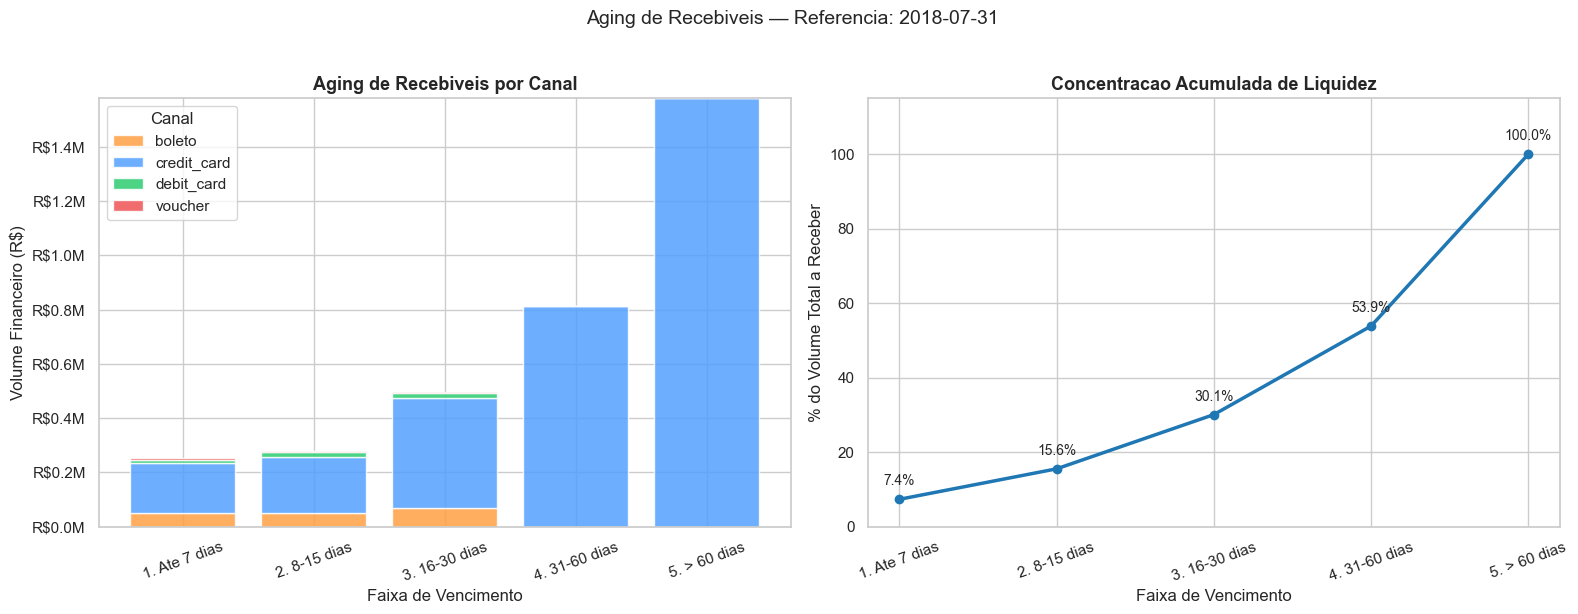

RELATORIO DE AGING — Referencia: 2018-07-31
payment_type     boleto   credit_card  debit_card  voucher         Total
faixa_aging                                                             
1. Ate 7 dias  52091.71  1.821553e+05    11212.31  6908.47  2.523678e+05
2. 8-15 dias   51990.69  2.037609e+05    18832.77  5268.87  2.798533e+05
3. 16-30 dias  68909.63  4.067372e+05    17064.60  5327.57  4.980390e+05
4. 31-60 dias    508.55  8.127128e+05        0.00   166.46  8.133879e+05
5. > 60 dias       0.00  1.577793e+06        0.00     0.00  1.577793e+06

--------------------------------------------------------------------------------
  Total de recebiveis futuros (R$):    3,421,441.35
  Proximos  7 dias           (R$):      252,367.80  (7.4%)
  Proximos 30 dias           (R$):    1,030,260.06  (30.1%)
  Proximos 60 dias           (R$):    1,843,647.91  (53.9%)


In [6]:
# =============================================================================
# MÓDULO 6: Análise de Aging de Recebíveis
# =============================================================================
# A curva de aging classifica os recebíveis futuros em faixas de vencimento
# para dimensionar o capital de giro em cada horizonte temporal.
#
# Faixas (a partir da data de referência 31/07/2018):
#   1. Até 7 dias  -> caixa imediato
#   2. 8–15 dias   -> curto prazo
#   3. 16–30 dias  -> médio prazo (1 mês)
#   4. 31–60 dias  -> médio prazo (2 meses)
#   5. > 60 dias   -> longo prazo / parcelas futuras de cartão
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

DATA_REF = pd.to_datetime('2018-07-31')

df_aging = df_fluxo_caixa[
    pd.to_datetime(df_fluxo_caixa['data_recebimento']) > DATA_REF
].copy()
df_aging['data_recebimento']  = pd.to_datetime(df_aging['data_recebimento'])
df_aging['dias_para_receber'] = (df_aging['data_recebimento'] - DATA_REF).dt.days

def faixa_aging(d):
    if   d <=  7: return '1. Ate 7 dias'
    elif d <= 15: return '2. 8-15 dias'
    elif d <= 30: return '3. 16-30 dias'
    elif d <= 60: return '4. 31-60 dias'
    else:         return '5. > 60 dias'

df_aging['faixa_aging'] = df_aging['dias_para_receber'].apply(faixa_aging)

resumo = (
    df_aging.groupby(['faixa_aging', 'payment_type'])['valor_recebido']
    .sum().unstack(fill_value=0)
)
resumo['Total'] = resumo.sum(axis=1)

sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

canais = [c for c in resumo.columns if c != 'Total']
cores  = {'boleto': '#ff9f43', 'credit_card': '#54a0ff', 'debit_card': '#2ecc71', 'voucher': '#ee5253'}
bot    = pd.Series(0.0, index=resumo.index)
for canal in canais:
    axes[0].bar(resumo.index, resumo[canal], bottom=bot,
                label=canal, color=cores.get(canal, '#aaa'), alpha=0.85)
    bot += resumo[canal]
axes[0].set_title('Aging de Recebiveis por Canal', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Volume Financeiro (R$)')
axes[0].set_xlabel('Faixa de Vencimento')
axes[0].tick_params(axis='x', rotation=20)
axes[0].legend(title='Canal')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x/1e6:.1f}M'))

tot  = resumo['Total'].values
acum = [tot[:i+1].sum() / tot.sum() * 100 for i in range(len(tot))]
axes[1].plot(resumo.index, acum, marker='o', color='#1f77b4', linewidth=2.5)
for x, y in zip(resumo.index, acum):
    axes[1].annotate(f'{y:.1f}%', (x, y), textcoords='offset points',
                     xytext=(0, 10), fontsize=10, ha='center')
axes[1].set_title('Concentracao Acumulada de Liquidez', fontsize=13, fontweight='bold')
axes[1].set_ylabel('% do Volume Total a Receber')
axes[1].set_xlabel('Faixa de Vencimento')
axes[1].set_ylim(0, 115)
axes[1].tick_params(axis='x', rotation=20)

plt.suptitle(f'Aging de Recebiveis — Referencia: {DATA_REF.date()}', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

total_fut = resumo['Total'].sum()
ate7  = resumo.loc[resumo.index == '1. Ate 7 dias',  'Total'].sum()
ate30 = resumo.loc[resumo.index <= '3. 16-30 dias',  'Total'].sum()
ate60 = resumo.loc[resumo.index <= '4. 31-60 dias',  'Total'].sum()

print('=' * 80)
print(f'RELATORIO DE AGING — Referencia: {DATA_REF.date()}')
print('=' * 80)
print(resumo.to_string())
print('\n' + '-' * 80)
print(f'  Total de recebiveis futuros (R$): {total_fut:>15,.2f}')
print(f'  Proximos  7 dias           (R$): {ate7:>15,.2f}  ({ate7/total_fut*100:.1f}%)')
print(f'  Proximos 30 dias           (R$): {ate30:>15,.2f}  ({ate30/total_fut*100:.1f}%)')
print(f'  Proximos 60 dias           (R$): {ate60:>15,.2f}  ({ate60/total_fut*100:.1f}%)')


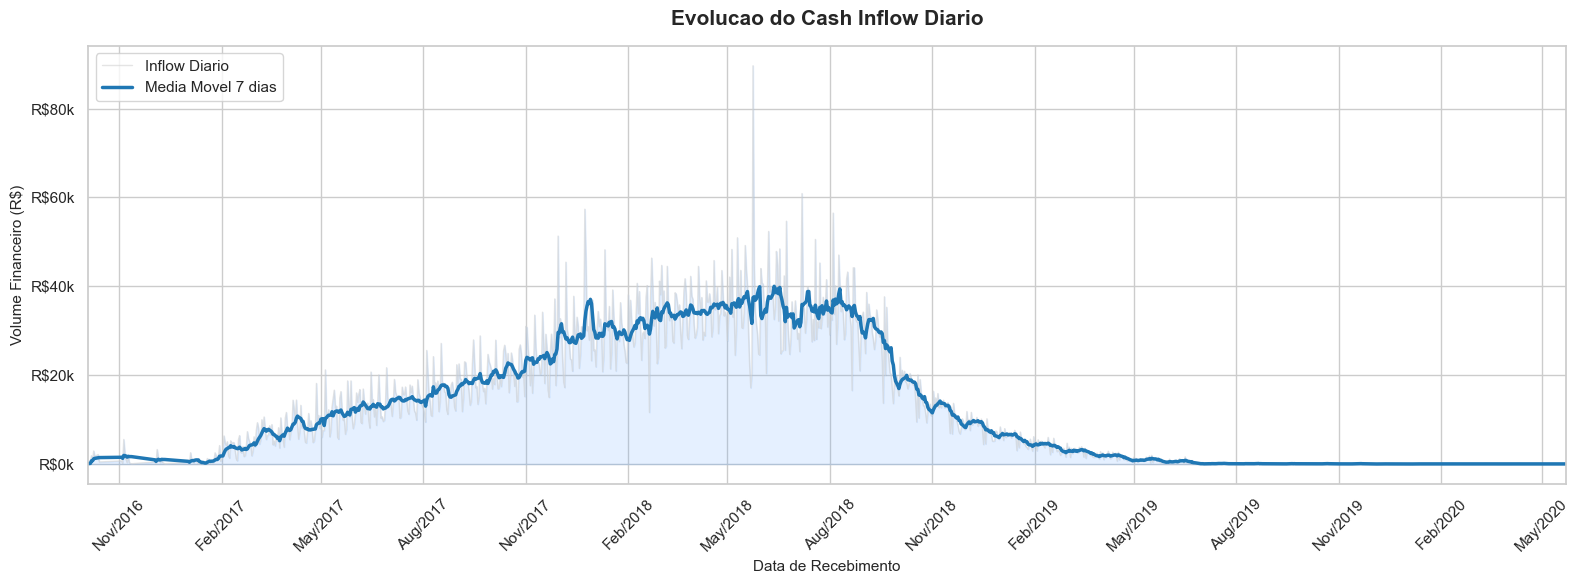

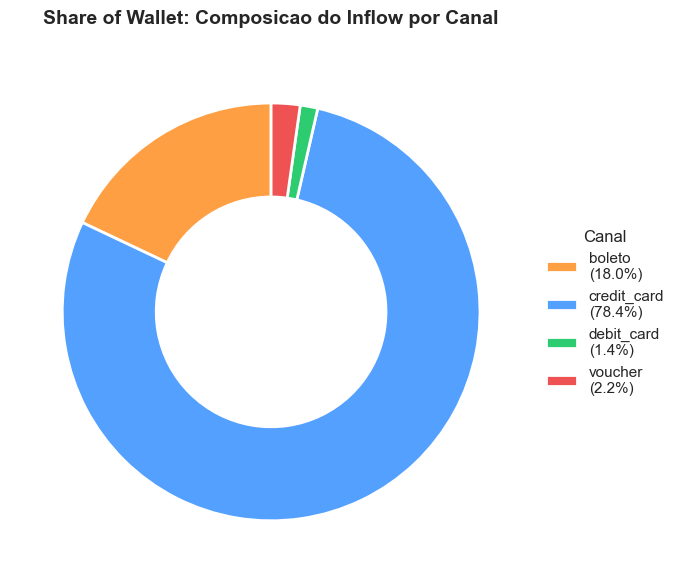

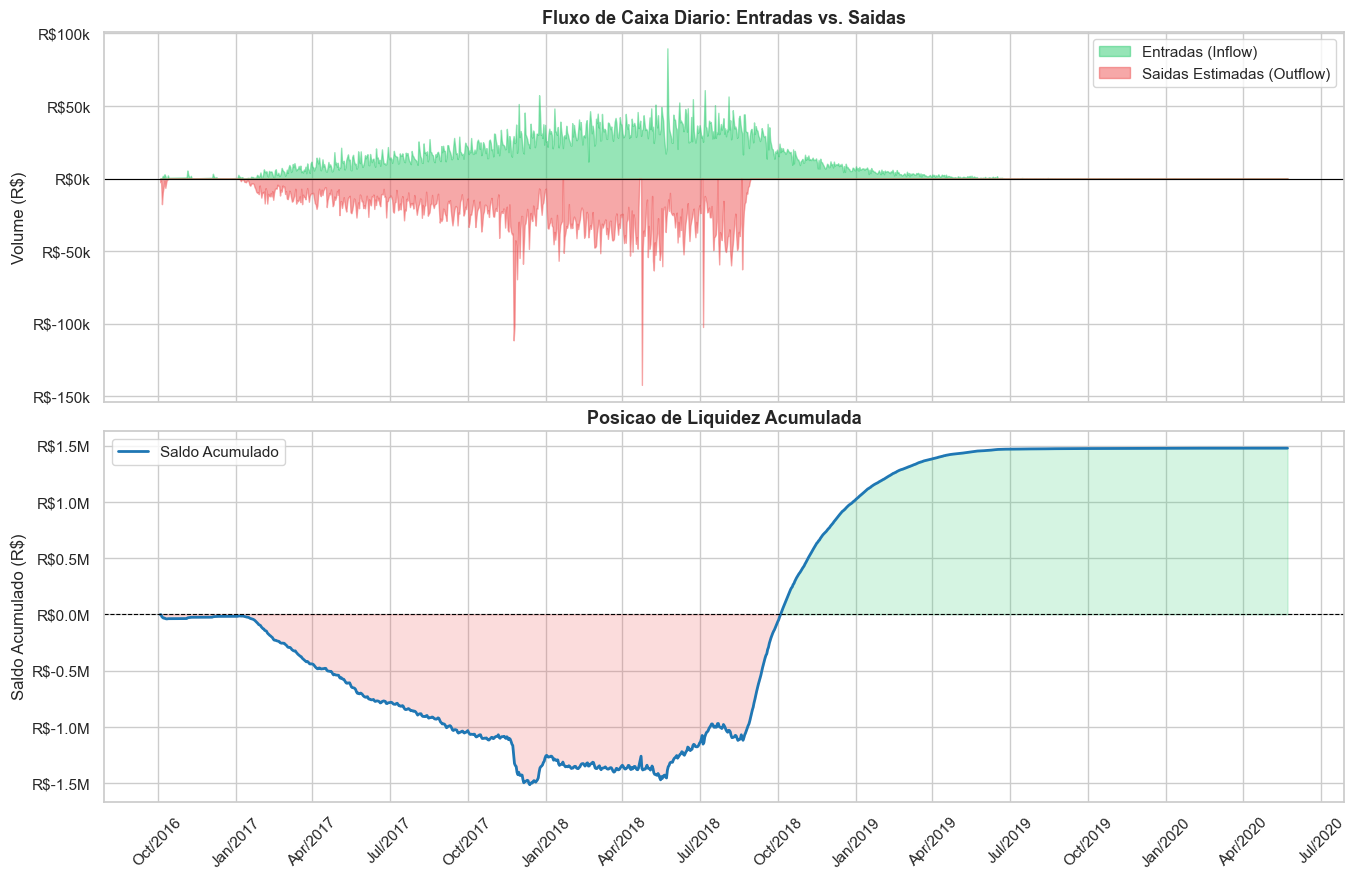

In [7]:
# =============================================================================
# MÓDULO 7: Visualização Analítica da Série Temporal de Caixa
# =============================================================================
# Graficos produzidos:
#   1. Inflow diario com media movel de 7 dias (tendencia estrutural)
#   2. Share of Wallet por canal de pagamento (rosca)
#   3. Entradas vs. Saidas + Saldo Acumulado (apenas se outflow disponivel)
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_theme(style='whitegrid')
CORES = {'boleto': '#ff9f43', 'credit_card': '#54a0ff', 'debit_card': '#2ecc71', 'voucher': '#ee5253'}

# Grafico 1: Serie Temporal com Media Movel
# A media movel suaviza a volatilidade intrassemanal e evidencia a tendencia.
df_relatorio_caixa['MM_7d'] = (
    df_relatorio_caixa['total_entradas_BRL'].rolling(window=7, min_periods=1).mean()
)

fig1, ax1 = plt.subplots(figsize=(16, 6))
ax1.fill_between(df_relatorio_caixa.index, df_relatorio_caixa['total_entradas_BRL'],
                 color='#54a0ff', alpha=0.15)
ax1.plot(df_relatorio_caixa.index, df_relatorio_caixa['total_entradas_BRL'],
         color='lightgray', alpha=0.6, linewidth=1, label='Inflow Diario')
ax1.plot(df_relatorio_caixa.index, df_relatorio_caixa['MM_7d'],
         color='#1f77b4', linewidth=2.5, label='Media Movel 7 dias')
ax1.set_title('Evolucao do Cash Inflow Diario', fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('Data de Recebimento', fontsize=11)
ax1.set_ylabel('Volume Financeiro (R$)', fontsize=11)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x/1000:.0f}k'))
ax1.set_xlim(df_relatorio_caixa.index.min(), df_relatorio_caixa.index.max())
ax1.legend(loc='upper left', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grafico 2: Share of Wallet
canais  = [c for c in ['boleto', 'credit_card', 'debit_card', 'voucher'] if c in df_relatorio_caixa.columns]
somas   = df_relatorio_caixa[canais].sum()
total_v = somas.sum()
labels  = [f'{c}\n({v/total_v*100:.1f}%)' for c, v in zip(canais, somas)]
cores   = [CORES.get(c, '#aaa') for c in canais]

fig2, ax2 = plt.subplots(figsize=(8, 6))
wedges, _ = ax2.pie(somas, startangle=90, colors=cores,
                    wedgeprops=dict(width=0.45, edgecolor='white', linewidth=2))
ax2.legend(wedges, labels, title='Canal', loc='center left',
           bbox_to_anchor=(1.0, 0.5), fontsize=11, title_fontsize=12, frameon=False)
ax2.set_title('Share of Wallet: Composicao do Inflow por Canal',
              fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Grafico 3: Entradas vs. Saidas + Saldo Acumulado
if _outflow_ok:
    fig3, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True,
                              gridspec_kw={'hspace': 0.08})

    axes[0].fill_between(df_saldo.index,  df_saldo['total_entradas_BRL'],
                         alpha=0.5, color='#2ecc71', label='Entradas (Inflow)')
    axes[0].fill_between(df_saldo.index, -df_saldo['total_saidas_BRL'],
                         alpha=0.5, color='#ee5253', label='Saidas Estimadas (Outflow)')
    axes[0].axhline(0, color='black', linewidth=0.8)
    axes[0].set_title('Fluxo de Caixa Diario: Entradas vs. Saidas',
                      fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Volume (R$)')
    axes[0].legend(fontsize=11)
    axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x/1000:.0f}k'))

    axes[1].plot(df_saldo.index, df_saldo['saldo_acumulado_BRL'],
                 color='#1f77b4', linewidth=2, label='Saldo Acumulado')
    axes[1].fill_between(df_saldo.index, df_saldo['saldo_acumulado_BRL'], 0,
                         where=(df_saldo['saldo_acumulado_BRL'] >= 0),
                         alpha=0.2, color='#2ecc71')
    axes[1].fill_between(df_saldo.index, df_saldo['saldo_acumulado_BRL'], 0,
                         where=(df_saldo['saldo_acumulado_BRL'] < 0),
                         alpha=0.2, color='#ee5253')
    axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axes[1].set_title('Posicao de Liquidez Acumulada', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Saldo Acumulado (R$)')
    axes[1].legend(fontsize=11)
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x/1e6:.1f}M'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Periodo de treino : 2017-07-31 -> 2018-07-31 (366 dias)
Media diaria      : R$ 29,013.45
Dias zerados      : 0 (0.0%)

Alpha (nivel)       : 0.0284
Beta  (tendencia)   : 0.0277
Gamma (sazonalidade): 0.0627



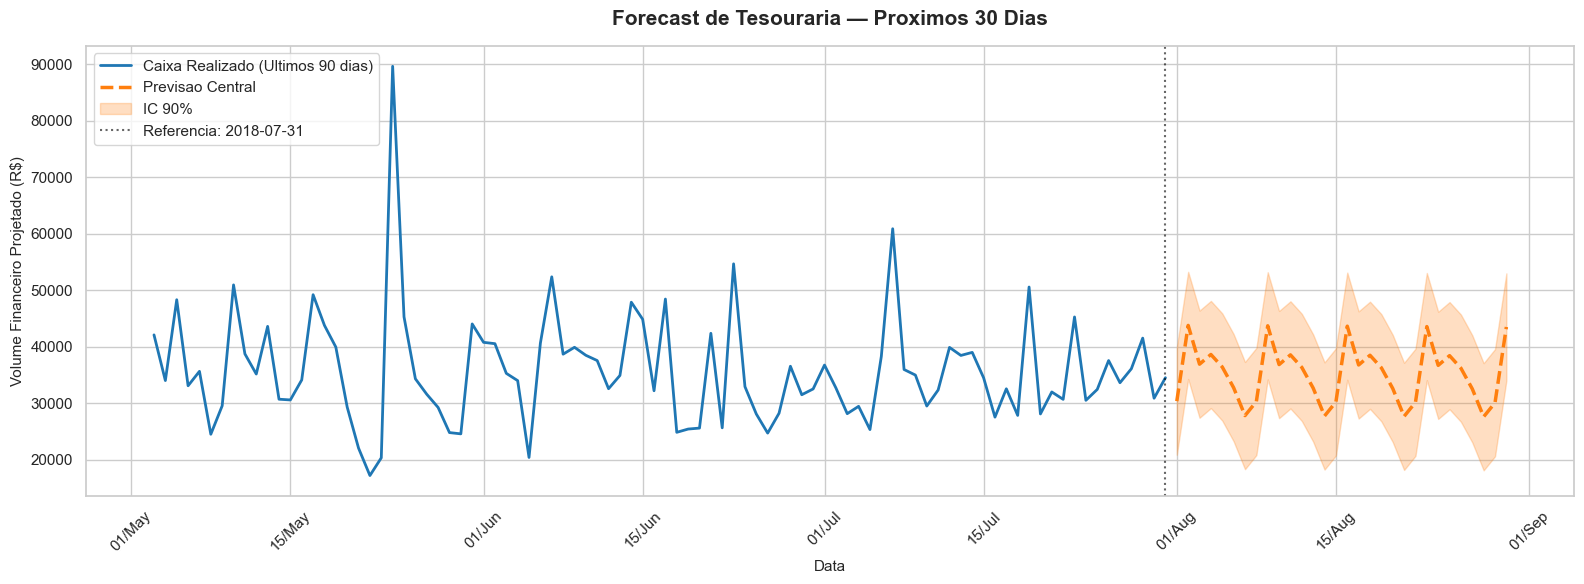

RELATORIO PREDITIVO DE LIQUIDEZ — PROXIMOS 30 DIAS
  Cenario Central (R$):    1,056,554.62
  Media Diaria    (R$):       35,218.49
  Estimativa p10  (R$):      771,883.04
  Estimativa p90  (R$):    1,341,226.19
  Amplitude IC    (R$):       18,978.11 /dia


In [8]:
# =============================================================================
# MÓDULO 8: Modelagem Preditiva de Fluxo de Caixa (Holt-Winters)
# =============================================================================
# Modelo: Suavizacao Exponencial Tripla (Holt-Winters)
#   Tendência   : aditiva — captura crescimento/queda linear da serie
#   Sazonalidade: aditiva, periodo 7 — padrao semanal de compensacao
#                 bancaria (boletos concentram recebimentos em dias uteis)
#
# JUSTIFICATIVA DA DATA DE CORTE (31/07/2018)
#   O dataset se estende ate 2020, mas os registros pos-2018 correspondem
#   apenas a recebiveis de parcelamentos antigos. O pico operacional ocorre
#   ate julho/2018, garantindo serie de treino estatisticamente representativa.
#
# LIMITACAO CONHECIDA
#   Zeros introduzidos em dias sem movimentacao (fill_value=0) distorcem
#   a componente sazonal. Alternativas: agregacao semanal ou modelo de
#   Croston para series intermitentes.
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

ts = df_relatorio_caixa['total_entradas_BRL'].copy()
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('D', fill_value=0)

DATA_CORTE  = pd.to_datetime('2018-07-31')
DATA_TREINO = DATA_CORTE - pd.Timedelta(days=365)
ts_treino   = ts[DATA_TREINO:DATA_CORTE]

print(f'Periodo de treino : {DATA_TREINO.date()} -> {DATA_CORTE.date()} ({len(ts_treino)} dias)')
print(f'Media diaria      : R$ {ts_treino.mean():,.2f}')
print(f'Dias zerados      : {(ts_treino == 0).sum()} ({(ts_treino == 0).mean()*100:.1f}%)\n')

modelo    = ExponentialSmoothing(ts_treino, trend='add', seasonal='add', seasonal_periods=7)
resultado = modelo.fit(optimized=True)

print(f'Alpha (nivel)       : {resultado.params["smoothing_level"]:.4f}')
print(f'Beta  (tendencia)   : {resultado.params["smoothing_trend"]:.4f}')
print(f'Gamma (sazonalidade): {resultado.params["smoothing_seasonal"]:.4f}\n')

N            = 30
previsao_30d = resultado.forecast(N).clip(lower=0)

# Bandas de incerteza — bootstrap de residuos, confianca 90%
# Banda inferior: reserva minima de capital de giro
# Banda superior: necessidade maxima de liquidez
std_res   = resultado.resid.std()
Z90       = 1.645
banda_sup = (previsao_30d + Z90 * std_res).clip(lower=0)
banda_inf = (previsao_30d - Z90 * std_res).clip(lower=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(ts_treino.index[-90:], ts_treino[-90:],
        color='#1f77b4', linewidth=2, label='Caixa Realizado (Ultimos 90 dias)')
ax.plot(previsao_30d.index, previsao_30d,
        color='#ff7f0e', linewidth=2.5, linestyle='--', label='Previsao Central')
ax.fill_between(previsao_30d.index, banda_inf, banda_sup,
                alpha=0.25, color='#ff7f0e', label='IC 90%')
ax.axvline(DATA_CORTE, color='black', linestyle=':', alpha=0.6,
           label=f'Referencia: {DATA_CORTE.date()}')
ax.set_title('Forecast de Tesouraria — Proximos 30 Dias', fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Data', fontsize=11)
ax.set_ylabel('Volume Financeiro Projetado (R$)', fontsize=11)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
ax.legend(loc='upper left', fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('=' * 70)
print(f'RELATORIO PREDITIVO DE LIQUIDEZ — PROXIMOS {N} DIAS')
print('=' * 70)
print(f'  Cenario Central (R$): {previsao_30d.sum():>15,.2f}')
print(f'  Media Diaria    (R$): {previsao_30d.mean():>15,.2f}')
print(f'  Estimativa p10  (R$): {banda_inf.sum():>15,.2f}')
print(f'  Estimativa p90  (R$): {banda_sup.sum():>15,.2f}')
print(f'  Amplitude IC    (R$): {(banda_sup - banda_inf).mean():>15,.2f} /dia')


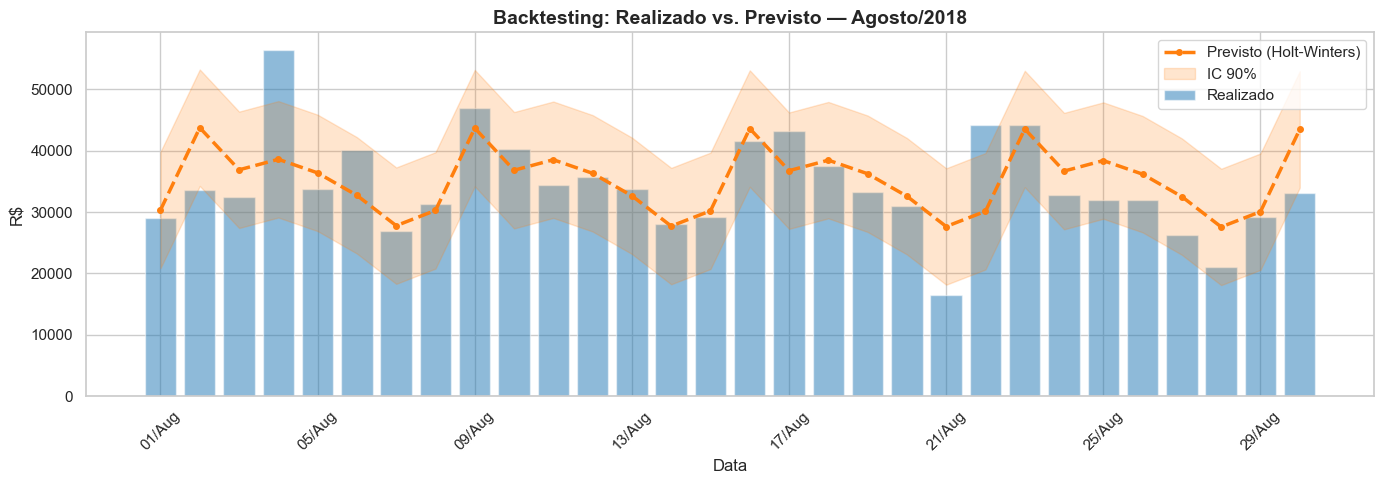

BACKTESTING OUT-OF-SAMPLE — AGOSTO/2018

Metrica                                  Holt-Winters          Naive
------------------------------------------------------------------------
MAE  — Erro Medio Absoluto (R$/dia)          4,593.72       7,306.37
RMSE — Erro Quadratico Medio (R$/dia)        6,301.86              —
MAPE — Erro Percentual Medio (%)                14.01          21.72
------------------------------------------------------------------------
Ganho HW vs. Naive (MAPE, p.p.)                 +7.71
Ganho HW vs. Naive (MAE, R$/dia)             +2712.65

INTERPRETACAO:
  O Holt-Winters erra em media R$ 4,593.72/dia (14.0% do realizado).
  Frente ao Naive (21.7%), entrega reducao de 7.7 p.p. no MAPE
  e ganho de R$ 2,712.65/dia no erro absoluto.
  Diagnostico: APROVADO


In [9]:
# =============================================================================
# MÓDULO 9: Validação Estatística do Modelo — Backtesting Out-of-Sample
# =============================================================================
# Metodologia:
#   O modelo foi treinado ate 31/07/2018; os dados de agosto/2018 foram
#   retidos exclusivamente para validacao (never-seen data).
#
# Metricas:
#   MAE  — erro absoluto medio em R$/dia (interpretacao direta de negocio)
#   RMSE — penaliza erros grandes (sensivel a picos de caixa)
#   MAPE — erro percentual medio (comparavel entre horizontes/series)
#
# Benchmark Naive:
#   Replica o valor do dia anterior como previsao.
#   Qualquer modelo com valor preditivo real deve superar este baseline.
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

D_INI = previsao_30d.index.min()
D_FIM = previsao_30d.index.max()

y_real = ts[D_INI:D_FIM]
y_prev = previsao_30d
y_real, y_prev = y_real.align(y_prev, join='inner')

mae_hw  = mean_absolute_error(y_real, y_prev)
rmse_hw = np.sqrt(mean_squared_error(y_real, y_prev))

def calc_mape(yt, yp):
    yt, yp = np.array(yt), np.array(yp)
    m = yt != 0
    return np.mean(np.abs((yt[m] - yp[m]) / yt[m])) * 100

mape_hw = calc_mape(y_real, y_prev)

y_naive        = ts[D_INI:D_FIM].shift(1).fillna(method='bfill')
y_naive, y_ral = y_naive.align(y_real, join='inner')
mae_n          = mean_absolute_error(y_ral, y_naive)
mape_n         = calc_mape(y_ral, y_naive)

# Visualizacao: Realizado vs. Previsto
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(y_real.index, y_real.values, color='#1f77b4', alpha=0.5, label='Realizado')
ax.plot(y_prev.index, y_prev.values, color='#ff7f0e', linewidth=2.5,
        linestyle='--', marker='o', markersize=4, label='Previsto (Holt-Winters)')
ax.fill_between(y_prev.index, banda_inf, banda_sup,
                alpha=0.2, color='#ff7f0e', label='IC 90%')
ax.set_title('Backtesting: Realizado vs. Previsto — Agosto/2018',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('R$')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
ax.legend(fontsize=11)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ganho_mape = mape_n  - mape_hw
ganho_mae  = mae_n   - mae_hw

print('=' * 72)
print('BACKTESTING OUT-OF-SAMPLE — AGOSTO/2018')
print('=' * 72)
print(f'{chr(10)}{"Metrica":<38} {"Holt-Winters":>14} {"Naive":>14}')
print('-' * 72)
print(f'{"MAE  — Erro Medio Absoluto (R$/dia)":<38} {mae_hw:>14,.2f} {mae_n:>14,.2f}')
print(f'{"RMSE — Erro Quadratico Medio (R$/dia)":<38} {rmse_hw:>14,.2f} {"—":>14}')
print(f'{"MAPE — Erro Percentual Medio (%)":<38} {mape_hw:>14.2f} {mape_n:>14.2f}')
print('-' * 72)
print(f'{"Ganho HW vs. Naive (MAPE, p.p.)":<38} {ganho_mape:>+14.2f}')
print(f'{"Ganho HW vs. Naive (MAE, R$/dia)":<38} {ganho_mae:>+14.2f}')

verdict = 'APROVADO' if ganho_mape > 0 else 'REVISAR — modelo nao supera o benchmark'
print('\n' + '=' * 72)
print('INTERPRETACAO:')
print('=' * 72)
print(f'  O Holt-Winters erra em media R$ {mae_hw:,.2f}/dia ({mape_hw:.1f}% do realizado).')
print(f'  Frente ao Naive ({mape_n:.1f}%), entrega reducao de {ganho_mape:.1f} p.p. no MAPE')
print(f'  e ganho de R$ {ganho_mae:,.2f}/dia no erro absoluto.')
print(f'  Diagnostico: {verdict}')
